In [19]:
import pandas as pd
import numpy as np

from nltk.stem import PorterStemmer
from nltk import sent_tokenize

from ast import literal_eval

from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

In [2]:
import setup_modules
from lib.preprocessing import process, ngram_enhance, setup_enhance
from lib.fomc import get_lname

In [52]:
fomc = pd.read_csv('../working-csvs/fomc.csv', index_col=0)
dfs = pd.read_csv('../working-csvs/raw_transcripts_sectioned.csv', index_col=0)

In [7]:
sg = dfs.groupby(['date', 'speaker', 'section'])['content'].agg(" ".join).reset_index()

In [5]:
sg['sentences'] = sg['content'].map(sent_tokenize)
sg.drop(['content'], axis=1, inplace=True)
sgs = sg.explode('sentences')
sgs.rename(columns={'sentences': 'content'}, inplace=True)

In [9]:
bigrams, trigrams = setup_enhance('../ngrams/bigrams', '../ngrams/trigrams')
sgs['enhanced'] = sgs['content'].map(lambda x : ngram_enhance(x, bigrams, trigrams))

In [12]:
stemmer = PorterStemmer()
sgs['tokens'] = sgs['enhanced'].map(lambda x : process(x, stemmer=stemmer))

In [13]:
sgs.iloc[:10]

,date,speaker,section,content,enhanced,tokens
0,1999-02-03,CHAIRMAN GREENSPAN.,1,That was a particularly impressive performance...,That was a particularly impressive performance...,"[particularli, impress, perform, three]"
0,1999-02-03,CHAIRMAN GREENSPAN.,1,I thought it most interesting in all respects.,I thought it most interesting in all respects.,"[thought, interest, respect]"
0,1999-02-03,CHAIRMAN GREENSPAN.,1,I found the results of the forecast scenario t...,I found the results of the forecast scenario t...,"[found, result, forecast, scenario, assum, lar..."
0,1999-02-03,CHAIRMAN GREENSPAN.,1,"If we look at the end result, we find that a s...","If we look at the end result, we find that a s...","[look, end, result, find, stock, market, bust,..."
0,1999-02-03,CHAIRMAN GREENSPAN.,1,Five or six years ago we thought 5 percent was...,Five or six years ago we thought 5 percent was...,"[five, six, year, ago, thought, percent, terri..."
0,1999-02-03,CHAIRMAN GREENSPAN.,1,The inflation rate in that scenario is under 2...,The inflation rate in that scenario is under 2...,"[inflat, rate, scenario, percent, inflation_r]"
0,1999-02-03,CHAIRMAN GREENSPAN.,1,"Again, that is something history would suggest...","Again, that is something history would suggest...","[someth, histori, would, suggest, fulli, accept]"
0,1999-02-03,CHAIRMAN GREENSPAN.,1,"So, if someone were to say that a bust in stoc...","So, if someone were to say that a bust in stoc...","[someon, say, bust, stock, market, price, woul..."
0,1999-02-03,CHAIRMAN GREENSPAN.,1,That tells us something about our inability to...,That tells us something about our inability to...,"[tell, us, someth, inabl, creat, limit, number..."
0,1999-02-03,CHAIRMAN GREENSPAN.,1,"As Dave Stockton pointed out, the endeavor to ...","As Dave Stockton pointed out, the endeavor to ...","[dave, stockton, point, endeavor, hold, everyt..."


In [20]:
topic_model = LdaModel.load('../models/12-10lda')
model_dict = Dictionary.load('../models/12-10dict')

In [21]:
sgs['probs'] = sgs['tokens'].map(lambda x : topic_model[model_dict.doc2bow(x)])

In [24]:
def topk_topics(topic_vec, k=3):
    probs = [item[1] for item in topic_vec]
    probs.sort(reverse=True)
    threshold = probs[k - 1]
    topk = [item for item in topic_vec if item[1] >= max(threshold, 0.03)]
    rounded = [(topic, round(prob,4)) for topic, prob in topk]
    return rounded
topk_topics(sgs.iloc[2]['probs'])

[(10, 0.0303), (12, 0.0397), (34, 0.0437)]

In [25]:
sgs['topk'] = sgs['probs'].map(lambda x : topk_topics(x, k=3))

In [28]:
for i, row in sgs.sample(20)[['content', 'topk']].iterrows():
    if len(row['topk']) > 0:
        print(row['content'])
        print(row['topk'])

One possible analogy is the 1980 Carter credit controls, when the government announced what seemed to be a tightening of credit.
[(8, 0.0715), (11, 0.041), (43, 0.0306)]
I'm concerned we have allowed our mantra of "data dependence" to become a liability.
[(14, 0.0408)]
Energy activity declined in January and, of course, people on the producing side have hopes--from their vantage point--for the oil price increases that they see stemming from the OPEC discussions.
[(6, 0.038), (10, 0.0713), (31, 0.0504)]
House prices continue to rise, leading to a decline in housing affordability.
[(1, 0.0513), (10, 0.0349)]
First, let me say with regard to the agency debt language, it is still $175 billion too high in my view.
[(24, 0.0565)]
On home equity lines, I find the numbers really remarkable.
[(1, 0.0354)]
Our staff's leading indicators of economic activity are signaling steady growth in all three states in our District over the next three quarters, and our business contacts appear optimistic.
[

In [29]:
from transformers import pipeline
pipe = pipeline("text-classification", model="ProsusAI/finbert")

/home/bdurham/miniconda3/envs/fed-nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-17 10:21:27.493688: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-17 10:21:27.685281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 10:21:27.685363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 10:21:27.717604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for 

In [30]:
pipe(["testing", "terrible inflation plaguing the country"])

[{'label': 'neutral', 'score': 0.8503028154373169},
 {'label': 'negative', 'score': 0.9071136713027954}]

In [31]:
sgs = sgs.reset_index().drop(columns=['index'], axis=1)
sgs['sentiment'] = pipe(sgs['content'].tolist())

In [32]:
sgs.to_csv('../working-csvs/sgs.csv')

In [33]:
sgs = pd.read_csv('../working-csvs/sgs.csv', index_col=0)
for col in ['tokens', 'probs', 'topk', 'sentiment']:
    sgs[col] = sgs[col].apply(literal_eval)
sgs

In [35]:
sgs['sentlabel'] = sgs['sentiment'].map(lambda x : x['label']).map({'neutral': 0, 'positive': 1, 'negative': '-1'})
sgs['sentscore'] = sgs['sentiment'].map(lambda x : x['score'])

In [45]:
fsgs = sgs[(sgs['topk'].map(len) > 0) & (sgs['sentscore'] > 0.5) & (sgs['sentlabel'] != 0)]

In [46]:
k = 45

def partial_stance_vect(topics, sent_label):
    # maybe normalize
    total = sum([topic[1] for topic in topics])
    svect = [0] * k
    for topic, weight in topics:
        svect[topic] = float(sent_label) * float(weight) / total
    
    irrelevant =np.ones(45)
    irrelevant[4] = 0
    irrelevant[20] = 0
    irrelevant[22] = 0
    irrelevant[27] = 0 
    return np.array(svect) * irrelevant

In [47]:
fsgs.loc[:,'svect'] = fsgs.apply(lambda x : partial_stance_vect(x['topk'], x['sentlabel']), axis=1)

/tmp/ipykernel_19734/1640508726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fsgs.loc[:,'svect'] = fsgs.apply(lambda x : partial_stance_vect(x['topk'], x['sentlabel']), axis=1)


In [48]:
fsgs.loc[:, 'speaker'] = fsgs['speaker'].map(get_lname)

In [53]:
fomc

,date,member,voter,pres,female,exp
0,1999-02-03,mcdonough,1,1,0.0,5.547945
1,1999-02-03,mcteer,1,1,0.0,8.010959
2,1999-02-03,boehne,1,1,0.0,18.016438
3,1999-02-03,stern,1,1,0.0,13.882192
4,1999-02-03,moskow,1,1,0.0,4.427397
...,...,...,...,...,...,...
2656,2017-12-13,mullinix,0,1,0.0,0.701370
2657,2017-12-13,mester,0,1,1.0,3.536986
2658,2017-12-13,george,0,1,1.0,6.205479
2659,2017-12-13,bullard,0,1,0.0,9.706849


In [55]:
fsgs = fsgs.merge(fomc, how='left', left_on=['date', 'speaker'], right_on=['date', 'member'])

In [57]:
fsgs

,date,speaker,section,content,enhanced,tokens,probs,topk,sentiment,sentlabel,sentscore,svect,member,voter,pres,female,exp
0,1999-02-03,greenspan,1,"If we look at the end result, we find that a s...","If we look at the end result, we find that a s...","[look, end, result, find, stock, market, bust,...","[(0, 0.021331787), (1, 0.02008242), (2, 0.0247...","[(9, 0.0347)]","{'label': 'negative', 'score': 0.9539210200309...",-1,0.953921,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",greenspan,1.0,0.0,0.0,11.490411
1,1999-02-03,greenspan,1,"So, if someone were to say that a bust in stoc...","So, if someone were to say that a bust in stoc...","[someon, say, bust, stock, market, price, woul...","[(0, 0.020012224), (1, 0.019443788), (2, 0.022...","[(9, 0.032), (11, 0.0341), (25, 0.0374)]","{'label': 'negative', 'score': 0.911649227142334}",-1,0.911649,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",greenspan,1.0,0.0,0.0,11.490411
2,1999-02-03,greenspan,1,I would presume that if the price of crude oil...,I would presume that if the price of crude oil...,"[would, presum, price, crude, oil, went, would...","[(0, 0.02159765), (1, 0.020465538), (2, 0.0202...","[(10, 0.0576), (31, 0.0344)]","{'label': 'negative', 'score': 0.8143059611320...",-1,0.814306,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",greenspan,1.0,0.0,0.0,11.490411
3,1999-02-03,greenspan,1,"Well, let's assume that the CPI weighting is w...","Well, let's assume that the CPI weighting is w...","[well, let, assum, cpi, weight, wrong, clearli...","[(0, 0.020901103), (1, 0.020222858), (2, 0.018...","[(19, 0.0324), (32, 0.0372), (34, 0.0314)]","{'label': 'negative', 'score': 0.7547101378440...",-1,0.754710,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",greenspan,1.0,0.0,0.0,11.490411
4,1999-02-03,greenspan,1,The point is that their perception of the infl...,The point is that their perception of the infl...,"[point, percept, inflat, rate, may, wrong, eco...","[(0, 0.020481486), (1, 0.02003508), (2, 0.0210...","[(20, 0.032), (25, 0.0348)]","{'label': 'negative', 'score': 0.7977304458618...",-1,0.797730,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",greenspan,1.0,0.0,0.0,11.490411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92639,2017-12-13,dudley,2,If the curve were to invert in the current env...,If the curve were to invert in the current env...,"[curv, invert, current, environ, would, peopl,...","[(0, 0.021819353), (1, 0.018862993), (2, 0.020...","[(6, 0.0309), (35, 0.0626)]","{'label': 'negative', 'score': 0.5716786980628...",-1,0.571679,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.330481283422...",dudley,1.0,1.0,0.0,8.882192
92640,2017-12-13,dudley,2,"Investors anticipate, if monetary policy is ti...","Investors anticipate, if monetary policy is ti...","[investor, anticip, monetari, polici, tight, e...","[(0, 0.022857606), (1, 0.020568049), (2, 0.021...","[(40, 0.0306)]","{'label': 'negative', 'score': 0.8797866106033...",-1,0.879787,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",dudley,1.0,1.0,0.0,8.882192
92641,2017-12-13,dudley,2,"In this cycle, I expect the yield curve will c...","In this cycle, I expect the yield curve will c...","[cycl, expect, yield, curv, continu, flatten, ...","[(0, 0.02012691), (1, 0.018331075), (2, 0.0330...","[(6, 0.0373), (19, 0.0333), (28, 0.0483)]","{'label': 'negative', 'score': 0.9108558297157...",-1,0.910856,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.313708999158...",dudley,1.0,1.0,0.0,8.882192
92642,2017-12-13,dudley,2,"But, to me, worrying now that we're committing...","But, to me, worrying now that we're committing...","[worri, commit, major, polici, mistak, rais, f...","[(0, 0.020604493), (1, 0.017746724), (2, 0.030...","[(3, 0.0551), (18, 0.0483), (20, 0.0366)]","{'label': 'negative', 'score': 0.8889493346214...",-1,0.888949,"[0.0, 0.0, 0.0, -0.39357142857142857, 0.0, 0.0...",dudley,1.0,1.0,0.0,8.882192


In [58]:
fsgs = fsgs[fsgs['voter'].notna()]

In [59]:
vdf = fsgs.groupby(['date', 'section', 'speaker'])[['svect','voter']].agg({'svect': 'sum', 'voter': 'max'}).reset_index()

In [64]:
vdf

,date,section,speaker,svect,voter
0,1999-02-03,1,boehne,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.813298121006...",1.0
1,1999-02-03,1,broaddus,"[0.0, 0.22751637879690292, 0.28740490278951814...",0.0
2,1999-02-03,1,ferguson,"[0.0, 0.0, -0.3704035874439462, 0.0, 0.0, 1.02...",1.0
3,1999-02-03,1,gramlich,"[0.0, -0.6131507733537453, 0.0, 0.0, 0.0, -0.6...",1.0
4,1999-02-03,1,greenspan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
...,...,...,...,...,...
4656,2017-12-13,2,powell,"[0.0, 0.0, 3.249530626685388, 0.0, 0.0, -0.365...",1.0
4657,2017-12-13,2,quarles,"[0.2632226322263222, 0.0, 3.9789766411944916, ...",1.0
4658,2017-12-13,2,rosengren,"[0.37258509659613614, 0.0, 0.3795712484237074,...",0.0
4659,2017-12-13,2,williams,"[0.4364820846905537, 0.3793103448275862, 3.772...",0.0


In [20]:
tm = vdf[(vdf['date'] == '2008-06-25') & (vdf['voter'] == 1) & (vdf['section'] == 2)].copy()
tm.loc[:, 'fisher'] = tm['speaker'] == 'fisher'
tm.loc[:, 'avg_group'] = tm.groupby('fisher')['svect'].transform('mean')
tm.loc[:, 'diff_avg'] = tm.loc[:,'svect'] - tm.loc[:,'avg_group']
tm.loc[:, 'diff_norm'] = tm.loc[:,'diff_avg'].map(np.linalg.norm)
# 214, 219
np.linalg.norm(tm.loc[381, 'avg_group'] - tm.loc[384, 'avg_group'])
tm

,date,section,speaker,svect,voter,fisher,avg_group,diff_avg,diff_norm
381,2008-06-25,2,bernanke,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.23350253807106597...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",2.021740
384,2008-06-25,2,fisher,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.35988483685220735,...",1.0,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.35988483685220735,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
385,2008-06-25,2,geithner,"[0.0, -0.38077969174977333, 0.0, -1.0, 0.0, 0....",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, -0.29914103111443696, -0.057695600068481...",2.131501
387,2008-06-25,2,kohn,"[0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -0.476470...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",2.074106
388,2008-06-25,2,kroszner,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5233644859813085, ...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",1.824512
391,2008-06-25,2,mishkin,"[0.0, -0.353968253968254, 0.0, -0.456393442622...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, -0.2723295933329176, -0.0576956000684814...",2.553171
392,2008-06-25,2,pianalto,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.58...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",1.361834
393,2008-06-25,2,plosser,"[0.0, 0.0, 0.5192604006163328, -0.410650887573...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, 0.46156480054785143...",3.086151
395,2008-06-25,2,stern,"[0.0, 0.0, 0.0, 0.32646755921730175, 0.0, 0.0,...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",1.525993
396,2008-06-25,2,warsh,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",1.044613


[0.274093   0.18916574]


[-0.34016787571910506,
 -1.4218781101263445,
 -0.047864273276409436,
 -0.16914569642767802,
 0.03143471724986504,
 -0.7468549306150842,
 -0.03665830767063272,
 3.0579414110249763,
 -0.24993702346497798,
 -0.07686991097460869]

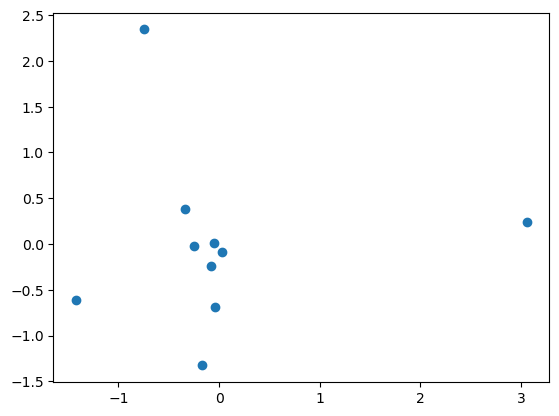

In [41]:
from sklearn.decomposition import PCA

X = tm['svect'].tolist()
y = tm['fisher'].map(int)


pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

import matplotlib.pyplot as plt

X_r

X_r1 = [item[0] for item in X_r]
X_r2 = [item[1] for item in X_r]

plt.scatter(X_r1, X_r2)

print(pca.explained_variance_ratio_)
X_r1

In [273]:
from sklearn.cluster import KMeans

X = tm['svect'].map(lambda x: x.tolist())
X = np.array(X.tolist())
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.predict(X)


/home/bdurham/miniconda3/envs/fed-nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [59]:
tm2 = vdf[(vdf['date'] == '2008-06-25')]

In [160]:
tm2_1 = tm2[tm2['section'] == 1]#.sample(frac=1).reset_index(drop=True)
tm2_2 = tm2[tm2['section'] == 2] #.sample(frac=1).reset_index(drop=True)

X1 = tm2_1['svect'].tolist()[:15]
X2 = tm2_2['svect'].tolist()[:15]

X1_test = tm2_1['svect'].tolist()[15:]
X2_test = tm2_2['svect'].tolist()[15:]

pca1 = PCA(n_components=6)
pca2 = PCA(n_components=6)

# print(pca1.fit_transform(X1))

# print(pca2.fit_transform(X2))

# b, _, _, _ = np.linalg.lstsq(X1, X2)
# b
# X2_hat = X1 @ b

# print(pca1.fit_transform(X2)[2])
# print(pca2.fit_transform(X2_hat)[2])

X1_hat = pca1.fit_transform(X1)
X2_hat = pca2.fit_transform(X2)
# print(X2_hat)
# print(X2_hat.T)
np.corrcoef(X1_hat.T, X2_hat.T).round(2)
# np.corrcoef(X1_hat, X2_hat).round(3)


array([[ 1.  , -0.  , -0.  ,  0.  , -0.  ,  0.  ,  0.32,  0.07, -0.35,
        -0.33,  0.13,  0.45],
       [-0.  ,  1.  , -0.  ,  0.  ,  0.  , -0.  ,  0.23,  0.04, -0.37,
         0.17, -0.33,  0.13],
       [-0.  , -0.  ,  1.  ,  0.  ,  0.  ,  0.  , -0.61,  0.23, -0.21,
        -0.22, -0.32,  0.2 ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  , -0.14, -0.21, -0.  ,
        -0.44, -0.02,  0.17],
       [-0.  ,  0.  ,  0.  ,  0.  ,  1.  , -0.  , -0.02,  0.3 ,  0.05,
         0.36,  0.41,  0.29],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ,  1.  ,  0.07,  0.57, -0.1 ,
        -0.29,  0.28, -0.3 ],
       [ 0.32,  0.23, -0.61, -0.14, -0.02,  0.07,  1.  , -0.  ,  0.  ,
        -0.  , -0.  ,  0.  ],
       [ 0.07,  0.04,  0.23, -0.21,  0.3 ,  0.57, -0.  ,  1.  , -0.  ,
         0.  ,  0.  ,  0.  ],
       [-0.35, -0.37, -0.21, -0.  ,  0.05, -0.1 ,  0.  , -0.  ,  1.  ,
        -0.  ,  0.  ,  0.  ],
       [-0.33,  0.17, -0.22, -0.44,  0.36, -0.29, -0.  ,  0.  , -0.  ,
         1.  , -0.  

In [123]:
pca1.components_

array([[ 2.38441547e-02, -1.71819140e-01,  1.67127965e-02,
        -3.30167716e-03,  0.00000000e+00,  1.16521382e-02,
        -1.09040563e-01,  1.94365398e-02, -5.07702435e-01,
        -4.70459523e-02, -6.73775205e-01, -1.30122435e-03,
         1.78548913e-02,  1.44457016e-02, -2.59207508e-02,
        -9.89167716e-02, -9.66898511e-02,  1.48262835e-01,
         3.87348530e-02, -1.13771716e-01,  0.00000000e+00,
         4.07914739e-02,  0.00000000e+00,  3.39101276e-02,
         1.37299911e-01,  1.16577065e-01, -3.16401263e-02,
         0.00000000e+00, -1.10994049e-02, -3.23780602e-02,
        -1.08026108e-02, -3.82561847e-02, -2.15016560e-01,
        -5.54243374e-03,  2.27672912e-02,  6.81948447e-02,
         1.64379280e-01,  0.00000000e+00, -9.88195671e-02,
        -1.87075204e-01,  2.44997804e-02,  5.15902332e-02,
        -1.65797614e-02,  1.31080052e-02,  1.43442494e-01],
       [ 1.98913101e-02,  6.81036092e-02,  9.14715925e-03,
        -3.66159027e-02,  6.93889390e-17,  6.01660765e-

In [122]:
pca1 = PCA().fit(X1)
pca2 = PCA().fit(X2)

t1_to_2 = pca1.components_ @ pca2.components_.T

mapped = np.dot(X1[0], t1_to_2)

ValueError: shapes (45,) and (15,15) not aligned: 45 (dim 0) != 15 (dim 0)

PCA OF EACH SECTION MAPPED OVER EACH OTHER

In [65]:
tm2.groupby('speaker')['svect'].agg(lambda x : np.ptp(np.stack(x), axis=0)).map(np.linalg.norm)

speaker
bernanke     8.962066
bullard      4.279339
evans        4.435498
fisher       4.749515
geithner     5.489499
hoenig       3.567919
kohn         4.793015
kroszner     3.994971
lacker       5.061400
lockhart     5.175702
mishkin      4.096773
pianalto     2.972476
plosser      5.764321
rosengren    4.725355
stern        2.683315
warsh        4.093230
yellen       5.119964
Name: svect, dtype: float64